# Assignment

- Stelios Kokkokyris - 3160063
- Ronald Toskollari - 3160244
- Vasilis Mavraganis - 3160091

## Importing our libraries

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

## Reading our datasets

Now we will read our train dataset

In [93]:
df_train = pd.read_csv('dataset/train.csv')
df_train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Checking the shape of our dataset

In [94]:
df_train.shape

(12165, 15)

## Preprocessing Our Data

Check existence of null values in the dataset:

In [95]:
df_train.isnull().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Luckily we can see that we do not have any null value on our dataset

Lets change column names for a nice precise reading:

In [96]:
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

Checking our changes:

In [97]:
df_train.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7,15,22
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9,59,68
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74,270,344
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3,219,222
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30,180,210


Check data type for each column:

In [98]:
df_train.dtypes

season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Some data types need to be changed from numerical to categorical in order for the model to interpret better these variables.

In [99]:
df_train['season'] = df_train.season.astype('category')
df_train['year'] = df_train.year.astype('category')
df_train['month'] = df_train.month.astype('category')
df_train['hour'] = df_train.hour.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['weekday'] = df_train.weekday.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['weather'] = df_train.weather.astype('category')

Lets confirm the converted data types:

In [100]:
df_train.dtypes

season        category
year          category
month         category
hour          category
holiday       category
weekday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity       float64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

## Exploratory Data Analysis

First of all we are going to deal with outliers and invalid data that we have in our dataset.

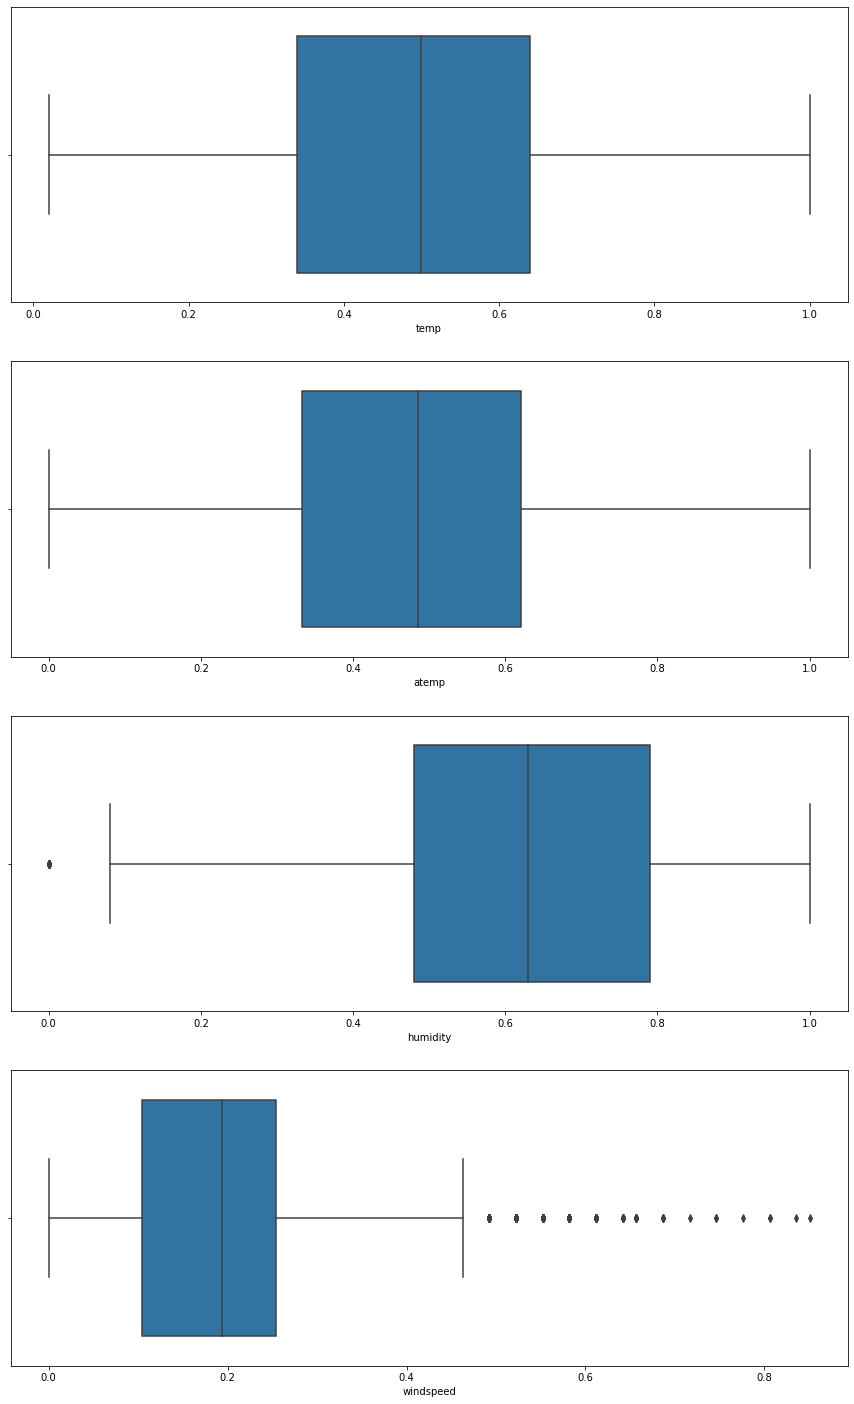

In [101]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4, figsize=(15,25))

sn.boxplot(x = df_train['temp'], ax = ax1)
sn.boxplot(x = df_train['atemp'], ax = ax2)
sn.boxplot(x = df_train['humidity'], ax = ax3)
sn.boxplot(x = df_train['windspeed'], ax = ax4)

As we can see from the boxplots above we have outliers on 2 features(humidity, windspeed). Se we are going to drop those columns. Below we detect and remove the outliers. We use Z-score function to detect the outliers.

In [102]:
z = np.abs(stats.zscore(df_train['humidity']))
df_train.shape

(12165, 15)

In [103]:
#df_train = df_train[z<3]
df_train.shape

(12165, 15)

We will do the same for windspeed

In [104]:
#z = np.abs(stats.zscore(df_train['windspeed']))
df_train.shape

(12165, 15)

In [105]:
df_train = df_train[z<3]
df_train.shape

(12147, 15)

Now that we have removed the outliers from our dataset let's check for invalid data on our dataset

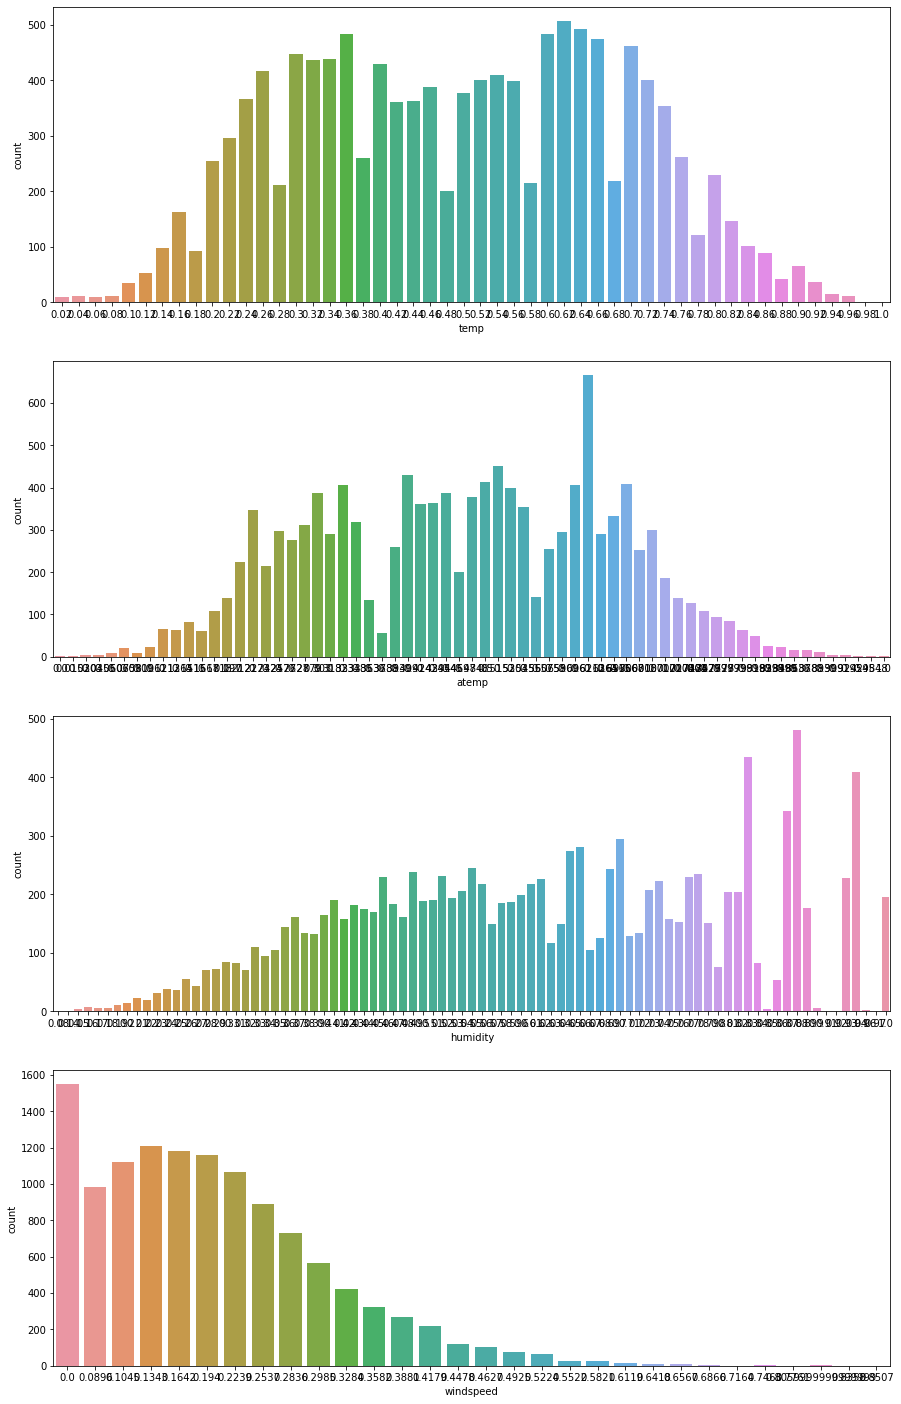

In [106]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(nrows=4, figsize=(15,25))
sn.countplot(x = df_train['temp'], ax = ax1)
sn.countplot(x = df_train['atemp'], ax = ax2)
sn.countplot(x = df_train['humidity'], ax = ax3)
sn.countplot(x = df_train['windspeed'], ax = ax4)

We can see now that windspeed seems to have many columns with zeros. This can be NaN, outliers, or correct values. Considering that we will build different models with and without windspeed.

Now let's analyze our categorical features

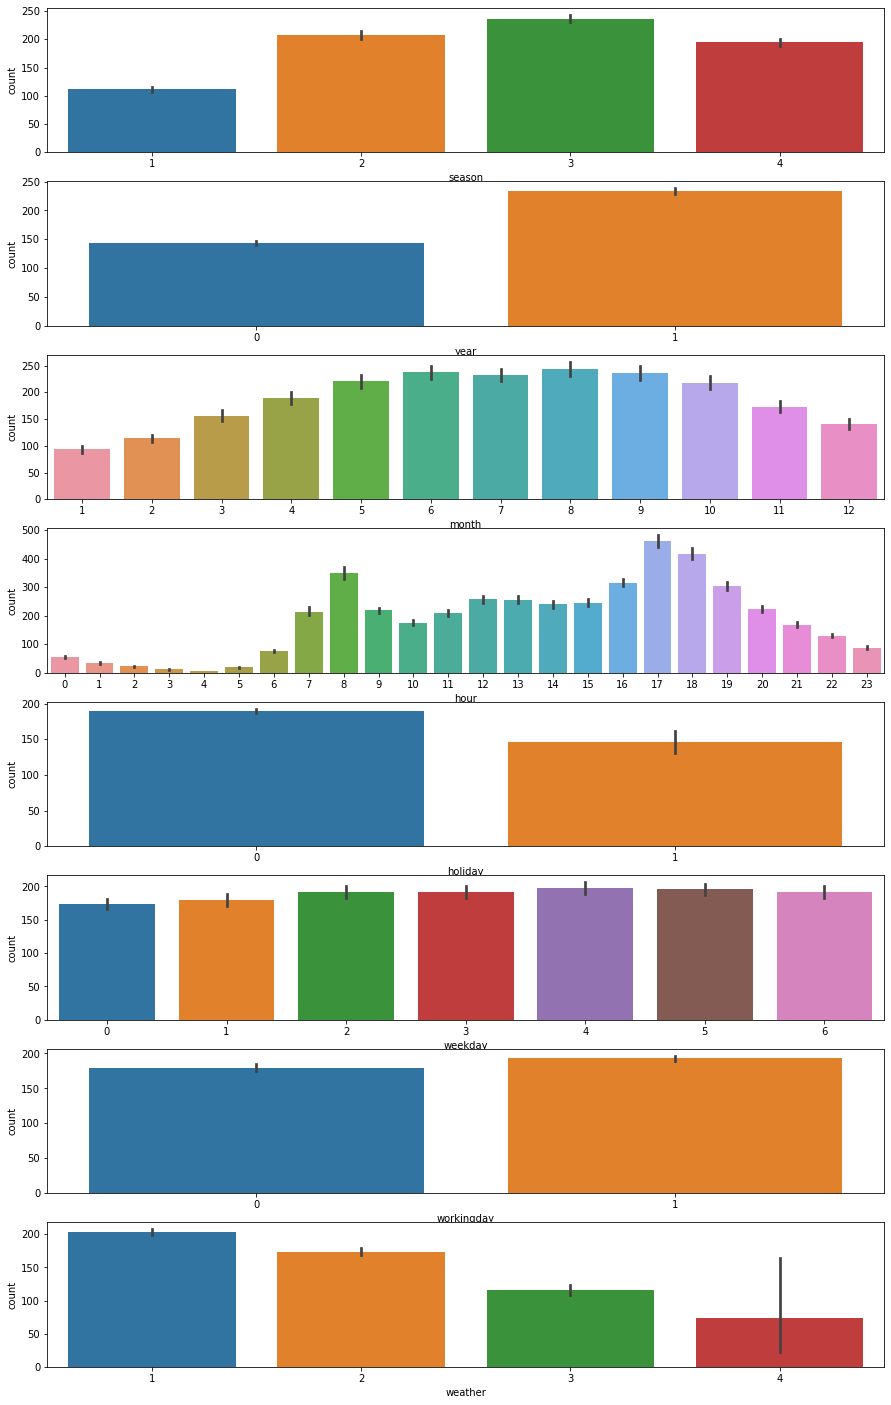

In [107]:
fig,[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8] = plt.subplots(nrows=8, figsize=(15,25))
sn.barplot(x = df_train['season'], y = df_train['count'],ax = ax1)
sn.barplot(x = df_train['year'], y = df_train['count'],ax = ax2)
sn.barplot(x = df_train['month'], y = df_train['count'],ax = ax3)
sn.barplot(x = df_train['hour'], y = df_train['count'],ax = ax4)
sn.barplot(x = df_train['holiday'], y = df_train['count'],ax = ax5)
sn.barplot(x = df_train['weekday'], y = df_train['count'],ax = ax6)
sn.barplot(x = df_train['workingday'], y = df_train['count'],ax = ax7)
sn.barplot(x = df_train['weather'], y = df_train['count'],ax = ax8)

We can see that every categorical feature has impact on our targer value which is count.

## Correlation Analysis

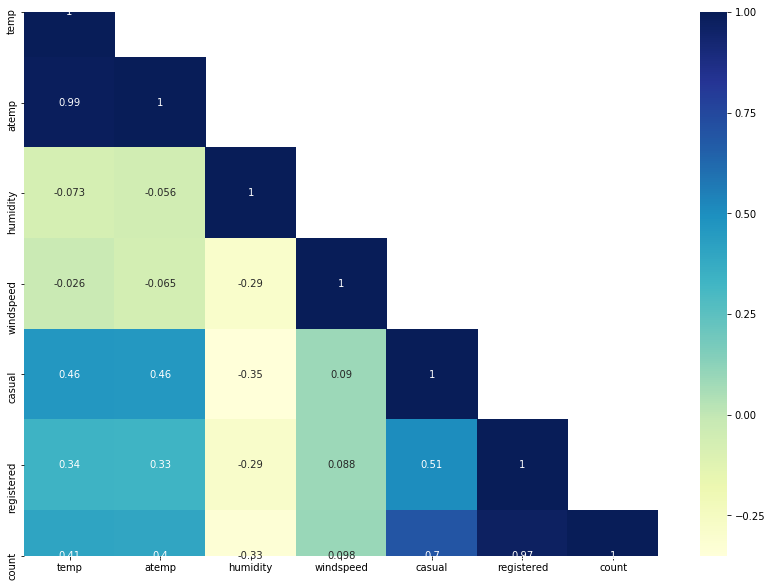

In [108]:
data_corr = df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sn.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True, cmap="YlGnBu")

It can be observed that:
- `temp` and `atemp` are strongly correlated.
- `casual` and `registered` contain direct information about the bike sharing `count` which we want to predict (data leakage). Therefore they are not considered in the feature set.
- `temp` has positive correlation and `humidity` has negative correlation with `count`.
- `windspeed` has little correlation with `count`.

## Model Building

### Model1

We are going to try many models with different parameters and features each model, so note that there might be some data preprocessing before model building. Let's start with a simple linear regression
- First we will try to use our current dataset as it is
- Second we will try to use one-hot encoding to our dataset
- K-Fold validation is used

In [109]:
df_train_copy = df_train.drop(columns = ['casual', 'registered'])

#Setting our features
X = df_train_copy.drop(columns='count').to_numpy()
#Setting our target
y = df_train_copy['count'].to_numpy()

scores = []
model1= LinearRegression()
cv = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cv.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    model1.fit(X_train, y_train)
    scores.append(model1.score(X_test, y_test))

Train Index:  [ 1215  1216  1217 ... 12144 12145 12146] 

Test Index:  [   0    1    2 ... 1212 1213 1214]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [1215 1216 1217 ... 2427 2428 2429]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [2430 2431 2432 ... 3642 3643 3644]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [3645 3646 3647 ... 4857 4858 4859]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [4860 4861 4862 ... 6072 6073 6074]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [6075 6076 6077 ... 7287 7288 7289]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [7290 7291 7292 ... 8502 8503 8504]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [8505 8506 8507 ... 9716 9717 9718]
Train Index:  [    0     1     2 ... 12144 12145 12146] 

Test Index:  [ 9719  9720  9721 ... 10930 10931 10932]
Train Index:  [    0     1     

In [110]:
print(np.mean(scores))

0.3888708876930414


As we can see our overall accuracy of the model is 0.38. Let's do some predictions

In [111]:
y_pred1 = model1.predict(X_test)

In [112]:
True in (y_pred1 < 0)

True

We observe that there are negative predictions. It has no physical meaning, and in order to be able to use RMSLE score  we convert these values to zero:

In [113]:
for i, y  in enumerate(y_pred1):
    if y_pred1[i] < 0:
        y_pred1[i] = 0

We check RMSLE and R-square scores. The R-square value is also very reasonable for this dataset which has a huge number of outliers.

In [114]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred1)))
print('R2:', r2_score(y_test, y_pred1))

RMSLE: 1.278521834867389
R2: 0.4250537244631053


To understand the performance of the model, a regression plot can be drawn between actual and predicted data. Bins are   used to make the pattern more meaningful.

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

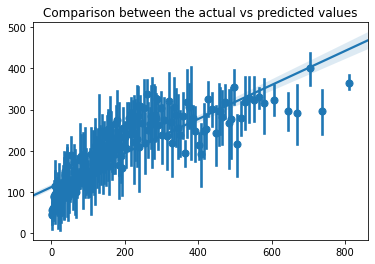

In [115]:
ax = sn.regplot(y_test, y_pred1, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

Our first model does not perform so well so let's try some extra feature engineering

### Model2

Before we create our model we will do some extra feature engineering. So let's start:
- First we are going to split our dataset into casual and registered users
- Second we will apply one-hot encoding algorithm 
- Third we are going to make predictions for both casual and registered users

### Splitting dataset to casual and registered dataset

#### Casual user's dataset

In [116]:
df_train_casual = df_train.drop(columns = ['registered', 'count'])
df_train_casual.rename(columns={'casual':'count'},inplace=True)
df_train_casual.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30


Below we detect and remove the outliers. We use Z-score function to detect the outliers.

In [117]:
z = np.abs(stats.zscore(df_train_casual['count']))
df_train_casual.shape

(12147, 13)

In [118]:
df_train_casual = df_train_casual[z<3]
df_train_casual.shape

(11814, 13)

Using one-hot encoding technique

In [119]:
df_train_casual = pd.get_dummies(df_train_casual, 
                                 prefix = ['season_', 'month_', 'hour_', 'weekday_', 'weather_'], 
                                 drop_first = True,
                                 columns = ['season', 'month', 'hour', 'weekday', 'weather'])



df_train_casual.head(5)

,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season__2,season__3,...,hour__23,weekday__1,weekday__2,weekday__3,weekday__4,weekday__5,weekday__6,weather__2,weather__3,weather__4
0,0,0,1,0.56,0.5303,0.64,0.3582,7,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0.28,0.2727,0.65,0.2537,9,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,0.44,0.4394,0.41,0.1940,74,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,1,0.18,0.1970,0.93,0.1642,3,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1,0,1,0.30,0.2727,0.45,0.2985,30,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Registered user's dataset

In [120]:
df_train_reg = df_train.drop(columns = ['casual', 'count'])
df_train_reg.rename(columns={'registered':'count'},inplace=True)
df_train_reg.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,15
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,59
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,270
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,219
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,180


Below we detect and remove the outliers. We use Z-score function to detect the outliers.

In [121]:
z = np.abs(stats.zscore(df_train_reg['count']))
df_train_reg.shape

(12147, 13)

In [122]:
df_train_reg = df_train_reg[z<3]
df_train_reg.shape

(11885, 13)

Using one-hot encoding technique

In [123]:
df_train_reg = pd.get_dummies(df_train_reg, 
                              prefix = ['season_', 'month_', 'hour_', 'weekday_', 'weather_'], 
                              drop_first = True,
                              columns = ['season', 'month', 'hour', 'weekday', 'weather'])

df_train_reg.head(5)

,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season__2,season__3,...,hour__23,weekday__1,weekday__2,weekday__3,weekday__4,weekday__5,weekday__6,weather__2,weather__3,weather__4
0,0,0,1,0.56,0.5303,0.64,0.3582,15,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0.28,0.2727,0.65,0.2537,59,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,0.44,0.4394,0.41,0.1940,270,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,1,0.18,0.1970,0.93,0.1642,219,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1,0,1,0.30,0.2727,0.45,0.2985,180,0,0,...,0,1,0,0,0,0,0,0,0,0


Ok now that we have splitted our dataset and used one-hot encoding let's continue with our model building

#### Model Builing

In [124]:
#casual users
X_casual = df_train_casual.drop(columns = ['count']).to_numpy()
y_casual = df_train_casual['count'].to_numpy()

#registered users
X_reg = df_train_reg.drop(columns = ['count']).to_numpy()
y_reg = df_train_reg['count'].to_numpy()

We are going to train 2 Linear Regression models one for casual users and the other for the registered users

In [125]:
#modelC is casual users regressor
scoresC = []
modelC = LinearRegression()
cvC = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cvC.split(X_casual):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_trainC, X_testC, y_trainC, y_testC = X_casual[train_index], X_casual[test_index], y_casual[train_index], y_casual[test_index]
    modelC.fit(X_trainC, y_trainC)
    scoresC.append(modelC.score(X_testC, y_testC))
    
#modelR is casual users regressor
scoresR = []
modelR = LinearRegression()
cvR = KFold(n_splits=10, random_state=42, shuffle=False)

for train_index, test_index in cvR.split(X_reg):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

    X_trainR, X_testR, y_trainR, y_testR = X_reg[train_index], X_reg[test_index], y_reg[train_index], y_reg[test_index]
    modelR.fit(X_trainR, y_trainR)
    scoresR.append(modelR.score(X_testR, y_testR))

Train Index:  [ 1182  1183  1184 ... 11811 11812 11813] 

Test Index:  [   0    1    2 ... 1179 1180 1181]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [1182 1183 1184 ... 2361 2362 2363]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [2364 2365 2366 ... 3543 3544 3545]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [3546 3547 3548 ... 4725 4726 4727]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [4728 4729 4730 ... 5906 5907 5908]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [5909 5910 5911 ... 7087 7088 7089]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [7090 7091 7092 ... 8268 8269 8270]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [8271 8272 8273 ... 9449 9450 9451]
Train Index:  [    0     1     2 ... 11811 11812 11813] 

Test Index:  [ 9452  9453  9454 ... 10630 10631 10632]
Train Index:  [    0     1     

Casual and registered users accuracy

In [126]:
print(np.mean(scoresC))
print(np.mean(scoresR))

0.6221268509942043
0.6617071509374469


Let's do some predictions for both casual and registered users 

In [127]:
y_predC = modelC.predict(X_testC)
y_predR = modelR.predict(X_testR)

In [128]:
True in (y_predC < 0)

True

In [129]:
True in (y_predR < 0)

True

In [130]:
for i, y  in enumerate(y_predC):
    if y_predC[i] < 0:
        y_predC[i] = 0
        
for i, y  in enumerate(y_predR):
    if y_predR[i] < 0:
        y_predR[i] = 0

We check RMSLE and R-square scores. The R-square value is also very reasonable for this dataset which has a huge number of outliers.

In [131]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_testC, y_predC)))
print('R2:', r2_score(y_testC, y_predC))

RMSLE: 0.9798147180992998
R2: 0.6643714889476405


In [132]:
print('RMSLE:', np.sqrt(mean_squared_log_error(y_testR, y_predR)))
print('R2:', r2_score(y_testR, y_predR))

RMSLE: 1.0385407785260972
R2: 0.6910131585379367


To understand the performance of the model, a regression plot can be drawn between actual and predicted data. Bins are   used to make the pattern more meaningful.

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

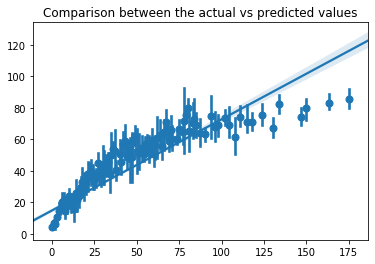

In [133]:
ax = sn.regplot(y_testC, y_predC, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

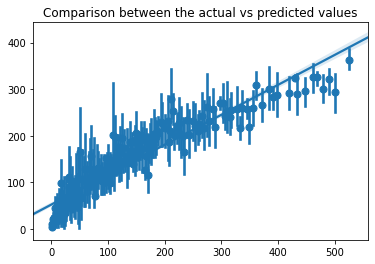

In [134]:
ax = sn.regplot(y_testR, y_predR, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

It seems that splitting our data performs better so we will keep tha change on our next models. Note that Linear Regression performs better with one-hot encoding.

### Model3

Our 3rd model is going to be a Random Forest Regressor.
- First we will split data into casual/registered
- Second we will build our models
- Third we are going to make some predictions

#### Casual user's dataset

In [135]:
df_train_casual = df_train.drop(columns = ['registered', 'count'])
df_train_casual.rename(columns={'casual':'count'},inplace=True)
df_train_casual.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30


Below we detect and remove the outliers. We use Z-score function to detect the outliers.

In [136]:
z = np.abs(stats.zscore(df_train_casual['count']))
df_train_casual.shape

(12147, 13)

In [137]:
df_train_casual = df_train_casual[z<3]
df_train_casual.shape

(11814, 13)

Transforming target feature

In [138]:
df_train_casual["count"] = np.log1p(df_train_casual["count"])

#### Registered user's dataset

In [139]:
df_train_reg = df_train.drop(columns = ['casual', 'count', 'windspeed'])
df_train_reg.rename(columns={'registered':'count'},inplace=True)
df_train_reg.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,15
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,59
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,270
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,219
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,180


Below we detect and remove the outliers. We use Z-score function to detect the outliers.

In [140]:
z = np.abs(stats.zscore(df_train_reg['count']))
df_train_reg.shape

(12147, 12)

In [141]:
df_train_reg = df_train_reg[z<3]
df_train_reg.shape

(11885, 12)

Transforming target feature

In [142]:
df_train_reg["count"] = np.log1p(df_train_reg["count"])

#### Model Builing

In [143]:
#modelC is casual users regressor
modelC = RandomForestRegressor(n_estimators=100)
# Training and test data is created by splitting the main data. 10% of test data is considered
X_casual = df_train_casual.drop(columns=['count'])
y_casual = df_train_casual['count']

X_trainC, X_testC, y_trainC, y_testC = train_test_split(X_casual, y_casual, test_size=0.1, random_state=42)
modelC.fit(X = X_trainC,y = y_trainC)
    
#modelR is registered users regressor
modelR = RandomForestRegressor(n_estimators=100)
# Training and test data is created by splitting the main data. 10% of test data is considered
X_reg = df_train_reg.drop(columns=['count'])
y_reg = df_train_reg['count']

X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_reg, y_reg, test_size=0.1, random_state=42)
modelR.fit(X = X_trainR,y = y_trainR)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Let's do some predictions for both casual and registered users 

In [144]:
y_predC = np.expm1(modelC.predict(X= X_testC))
y_predR = np.expm1(modelR.predict(X= X_testR))

In [145]:
True in (y_predC < 0)

False

In [146]:
True in (y_predR < 0)

False

In [147]:
for i, y  in enumerate(y_predC):
    if y_predC[i] < 0:
        y_predC[i] = 0
        
for i, y  in enumerate(y_predR):
    if y_predR[i] < 0:
        y_predR[i] = 0

We check RMSLE and R-square scores. The R-square value is also very reasonable for this dataset which has a huge number of outliers.

In [148]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.expm1(y_testC), y_predC)))
print('R2:', r2_score(np.expm1(y_testC), y_predC))

RMSLE: 0.5102043953561906
R2: 0.8492119000951756


In [149]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.expm1(y_testR), y_predR)))
print('R2:', r2_score(np.expm1(y_testR), y_predR))

RMSLE: 0.3196823022680405
R2: 0.9217678850615154


To understand the performance of the model, a regression plot can be drawn between actual and predicted data. Bins are   used to make the pattern more meaningful.

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

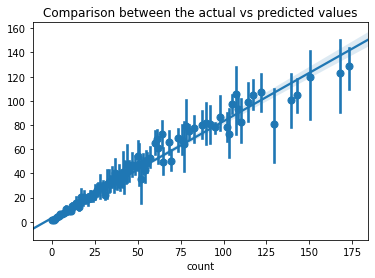

In [150]:
ax = sn.regplot(np.expm1(y_testC), y_predC, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

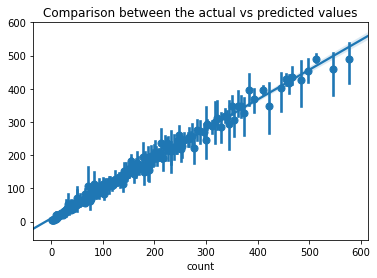

In [151]:
ax = sn.regplot(np.expm1(y_testR), y_predR, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

#### Model4

Our 4th model is going to be Gradient Boost Regressor:
- First we split casual/registered users
- Second we build our model
- Third we test our model

#### Casual user's dataset

In [182]:
df_train_casual = df_train.drop(columns = ['registered', 'count'])
df_train_casual.rename(columns={'casual':'count'},inplace=True)
df_train_casual.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,0.3582,7
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,0.2537,9
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,0.1940,74
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,0.1642,3
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,0.2985,30


Transforming target data

In [183]:
df_train_casual['count'] = np.log1p(df_train_casual['count'])

#### Registered user's dataset

In [184]:
df_train_reg = df_train.drop(columns = ['casual', 'count', 'windspeed'])
df_train_reg.rename(columns={'registered':'count'},inplace=True)
df_train_reg.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,count
0,4,0,11,0,0,2,1,1,0.56,0.5303,0.64,15
1,1,0,2,21,0,6,0,1,0.28,0.2727,0.65,59
2,4,1,11,12,0,3,1,1,0.44,0.4394,0.41,270
3,1,1,1,7,0,2,1,2,0.18,0.1970,0.93,219
4,1,1,3,16,0,1,1,1,0.30,0.2727,0.45,180


Transforming targer data

In [185]:
df_train_reg['count'] = np.log1p(df_train_reg['count'])

#### Model Building

In [230]:
#modelC is casual users regressor
modelC = GradientBoostingRegressor(n_estimators=4500, criterion='mse')
# Training and test data is created by splitting the main data. 10% of test data is considered
X_casual = df_train_casual.drop(columns=['count'])
y_casual = df_train_casual['count']

X_trainC, X_testC, y_trainC, y_testC = train_test_split(X_casual, y_casual, test_size=0.1, random_state=42)
modelC.fit(X_trainC, y_trainC)
    
#modelR is registered users regressor
modelR = GradientBoostingRegressor(n_estimators=4000, alpha=0.1, criterion='mse')
# Training and test data is created by splitting the main data. 10% of test data is considered
X_reg = df_train_reg.drop(columns=['count'])
y_reg = df_train_reg['count']

X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_reg, y_reg, test_size=0.1, random_state=42)
modelR.fit(X_trainR, y_trainR)

GradientBoostingRegressor(alpha=0.1, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Let's do some predictions for both casual and registered users 

In [231]:
y_predC = np.expm1(modelC.predict(X_testC))
y_predR = np.expm1(modelR.predict(X_testR))

In [232]:
True in (y_predC < 0)

True

In [233]:
True in (y_predR < 0)

False

In [234]:
for i, y  in enumerate(y_predC):
    if y_predC[i] < 0:
        y_predC[i] = 0
        
for i, y  in enumerate(y_predR):
    if y_predR[i] < 0:
        y_predR[i] = 0

We check RMSLE and R-square scores. The R-square value is also very reasonable for this dataset which has a huge number of outliers.

In [235]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.expm1(y_testC), y_predC)))
print('R2:', r2_score(np.expm1(y_testC), y_predC))

RMSLE: 0.47917813585818614
R2: 0.9104289288828612


In [236]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.expm1(y_testR), y_predR)))
print('R2:', r2_score(np.expm1(y_testR), y_predR))

RMSLE: 0.2926451182903458
R2: 0.9523182171620128


To understand the performance of the model, a regression plot can be drawn between actual and predicted data. Bins are   used to make the pattern more meaningful.

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

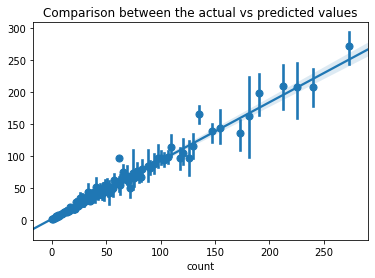

In [237]:
ax = sn.regplot(np.expm1(y_testC), y_predC, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

[Text(0.5, 1.0, 'Comparison between the actual vs predicted values')]

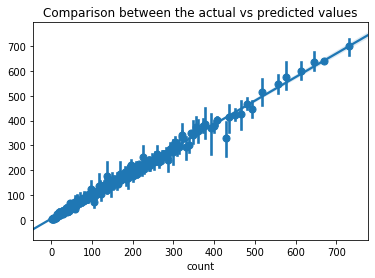

In [238]:
ax = sn.regplot(np.expm1(y_testR), y_predR, x_bins = 200)
ax.set(title = "Comparison between the actual vs predicted values")

#### Model5

Our model 5 is going to be a neural network:
- First we will apply one-hot encoding to our data
- Second we will create our model
- Third we will test our model

#### Data Preprocessing

In [165]:
df_train_copy = df_train.drop(columns = ['casual', 'registered'])

Using one-hot encoding technique

In [166]:
df_train_copy = pd.get_dummies(df_train_copy, 
                              prefix = ['season_', 'month_', 'hour_', 'weekday_', 'weather_'], 
                              drop_first = True,
                              columns = ['season', 'month', 'hour', 'weekday', 'weather'])
df_train_copy = df_train_copy.drop(columns = 'weather__4')
df_train_copy.head(5)

,year,holiday,workingday,temp,atemp,humidity,windspeed,count,season__2,season__3,...,hour__22,hour__23,weekday__1,weekday__2,weekday__3,weekday__4,weekday__5,weekday__6,weather__2,weather__3
0,0,0,1,0.56,0.5303,0.64,0.3582,22,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0.28,0.2727,0.65,0.2537,68,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,1,0.44,0.4394,0.41,0.1940,344,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,1,0.18,0.1970,0.93,0.1642,222,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1,0,1,0.30,0.2727,0.45,0.2985,210,0,0,...,0,0,1,0,0,0,0,0,0,0


Transfroming target 

In [167]:
df_train_copy['count'] = np.log1p(df_train_copy['count'])

#### Model Building

In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2


# Training and test data is created by splitting the main data. 30% of test data is considered
X = df_train_copy.drop(columns=['count'])
y = df_train_copy['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#creating NN

model = Sequential()
model.add(Dense(200, input_dim=52, kernel_initializer='normal', activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               10600     
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
_________________________________________________________________


In [169]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [170]:
model.fit(X_train, y_train, epochs=20, batch_size=50,  verbose=1)

Train on 10932 samples
Epoch 1/20
10932/10932 [==============================] - 1s 78us/sample - loss: 1.5310 - mse: 1.5310
Epoch 2/20
10932/10932 [==============================] - 1s 69us/sample - loss: 0.1505 - mse: 0.1505
Epoch 3/20
10932/10932 [==============================] - 1s 69us/sample - loss: 0.1214 - mse: 0.1214
Epoch 4/20
10932/10932 [==============================] - 1s 66us/sample - loss: 0.1126 - mse: 0.1126
Epoch 5/20
10932/10932 [==============================] - 1s 67us/sample - loss: 0.1066 - mse: 0.1066
Epoch 6/20
10932/10932 [==============================] - 1s 74us/sample - loss: 0.0992 - mse: 0.0992
Epoch 7/20
10932/10932 [==============================] - 1s 69us/sample - loss: 0.0982 - mse: 0.0982
Epoch 8/20
10932/10932 [==============================] - 1s 72us/sample - loss: 0.0934 - mse: 0.0934
Epoch 9/20
10932/10932 [==============================] - 1s 74us/sample - loss: 0.0901 - mse: 0.0901
Epoch 10/20
10932/10932 [==============================] - 

Let's do some predictions for both casual and registered users 

In [171]:
y_pred = np.expm1(model.predict(X_test))

In [172]:
True in (y_pred < 0)

False

In [173]:
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

We check RMSLE and R-square scores. The R-square value is also very reasonable for this dataset which has a huge number of outliers.

In [174]:
print('RMSLE:', np.sqrt(mean_squared_log_error(np.expm1(y_test), y_pred)))
print('R2:', r2_score(np.expm1(y_test), y_pred))

RMSLE: 0.3242667525847681
R2: 0.9076442863482199


### Testing test dataset

Now we will test our models on the test dataset

In [239]:
filename = 'dataset/test.csv' 
df_test = pd.read_csv(filename)
df_test.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,20,0,4,1,1,0.26,0.2121,0.52,0.4478
1,4,1,10,15,0,5,1,1,0.52,0.5000,0.42,0.4478
2,1,0,1,10,0,0,0,1,0.22,0.2121,0.51,0.2836
3,3,1,8,18,0,3,1,1,0.74,0.6667,0.51,0.2239
4,1,1,2,8,0,1,1,1,0.24,0.2424,0.60,0.0000


In [240]:
df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

In [243]:
df_test1 = df_test.drop(columns = ['windspeed'])
#df_test = df_test.drop(columns = ['windspeed'])

In [244]:
df_test.shape

(5214, 12)

In [245]:
y_pred = np.expm1(modelC.predict(df_test)) + np.expm1(modelR.predict(df_test1))
#y_pred = np.expm1(model.predict(df_test))

In [246]:
True in (y_pred < 0)
for i, y  in enumerate(y_pred):
    if y_pred[i] < 0:
        y_pred[i] = 0

In [247]:
submission = pd.DataFrame()
submission['Id'] = range(y_pred.shape[0])
submission['Predicted'] = y_pred

In [248]:
submission.to_csv("submission_vrs.csv", index=False)